In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [28]:
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [27]:
from xgboost import XGBClassifier

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [53]:
labeledData = pd.read_csv(r'Data/LabelData.csv')
labeledData2 = pd.read_csv(r'Data/LabelData.csv')
UnlabeledData = pd.read_csv(r'Data/UnlabelData.csv')
labeledData.head(10)


user_id  age  male  friend_cnt  avg_friend_age  avg_friend_male  \
0       10   24     0          20       26.333333         0.777778   
1       58   29     1          12       26.900000         0.818182   
2       72   22     0           4       21.000000         1.000000   
3      121   27     0           1       29.000000         1.000000   
4      137   22     1           4       21.250000         0.750000   
5      261   21     1           2       23.000000         0.500000   
6      270   18     1          27       23.473684         0.500000   
7      281   23     1          21       28.400000         0.687500   
8      320   23     1           5       25.500000         0.800000   
9      322   21     1           2       24.000000         0.500000   

   friend_country_cnt  subscriber_friend_cnt  songsListened  lovedTracks  ...  \
0                   6                      0          37804            4  ...   
1                   6                      1          15955           19  ...   
2                   2                      0          31441            7  ...   
3                   1                      0              0            0  ...   
4                   1                      0            774            0  ...   
5                   1                      0           5098            0  ...   
6                  12                      0          84287            5  ...   
7                   9                      2          16498            0  ...   
8                   1                      1          14823            1  ...   
9                   1                      0          12643            0  ...   

   delta_subscriber_friend_cnt  delta_songsListened  delta_lovedTracks  \
0                            0                   54                  0   
1                            0                  802                  0   
2                            0                    0                  0   
3                            0                    0                  0   
4                            0                    0                  0   
5                            0                    0                  0   
6                            0                    0                  0   
7                            0                    0                  0   
8                            0                    0                  0   
9                            0                    0                  0   

   delta_posts  delta_playlists  delta_shouts  tenure  good_country  \
0            0                0             0      79             0   
1            0                0             1      80             0   
2            0                0             0      53             0   
3            0                0             0      59             0   
4            0                0             0      60             0   
5            0                0             0      59             0   
6            0                0             0      59             0   
7            0                0             0      60             0   
8            0                0             0      59             0   
9            0                0             0      68             0   

   delta_good_country  adopter  
0                   0        0  
1                   0        0  
2                   0        0  
3                   0        0  
4                   0        0  
5                   0        0  
6                   0        0  
7                   0        0  
8                   0        0  
9                   0        0  

[10 rows x 27 columns]

In [36]:
# Split the labeled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    labeledData.drop(['adopter', 'user_id'], axis=1),
    labeledData['adopter'],
    test_size=0.3,
    random_state=42
)

# Determine the class imbalance in the training set
class_counts = y_train.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
minority_class_count = class_counts[minority_class]
majority_class_count = class_counts[majority_class]
class_ratio = minority_class_count / majority_class_count

# Over sampling method
print("RandomOverSampler")
sampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# Train and evaluate the model on the resampled training set
logreg = LogisticRegression(solver='newton-cg')
logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set and calculate the F1 score
y_pred = logreg.predict(X_val)
f1 = f1_score(y_val, y_pred)
print("F1 score:", f1)


RandomOverSampler
F1 score: 0.07259528130671507


# Exploratory Data Analysis (EDA)

- Analyze the data to gain insights into the relationships between different features and the target variable (adopter).
- Plot histograms, boxplots, and scatterplots to visualize the data distribution and identify potential outliers.

In [30]:
# Scale continuous variables
continuous_columns = [
    "age", "friend_cnt", "avg_friend_age", "avg_friend_male", "friend_country_cnt",
    "subscriber_friend_cnt", "songsListened", "lovedTracks", "posts", "playlists", "shouts",
    "delta_friend_cnt", "delta_avg_friend_age", "delta_avg_friend_male", "delta_friend_country_cnt",
    "delta_subscriber_friend_cnt", "delta_songsListened", "delta_lovedTracks", "delta_posts", "delta_playlists", "delta_shouts", "tenure"
]

scaler = MinMaxScaler()
labeledData[continuous_columns] = scaler.fit_transform(labeledData[continuous_columns])
labeledData.head(1)


user_id       age  male  friend_cnt  avg_friend_age  avg_friend_male  \
0       10  0.225352     0    0.002952        0.254902         0.777778   

   friend_country_cnt  subscriber_friend_cnt  songsListened  lovedTracks  ...  \
0             0.04918                    0.0       0.040986     0.000071  ...   

   delta_subscriber_friend_cnt  delta_songsListened  delta_lovedTracks  \
0                     0.424242             0.333894           0.016429   

   delta_posts  delta_playlists  delta_shouts    tenure  good_country  \
0     0.000079              0.2      0.181343  0.709091             0   

   delta_good_country  adopter  
0                   0        0  

[1 rows x 27 columns]

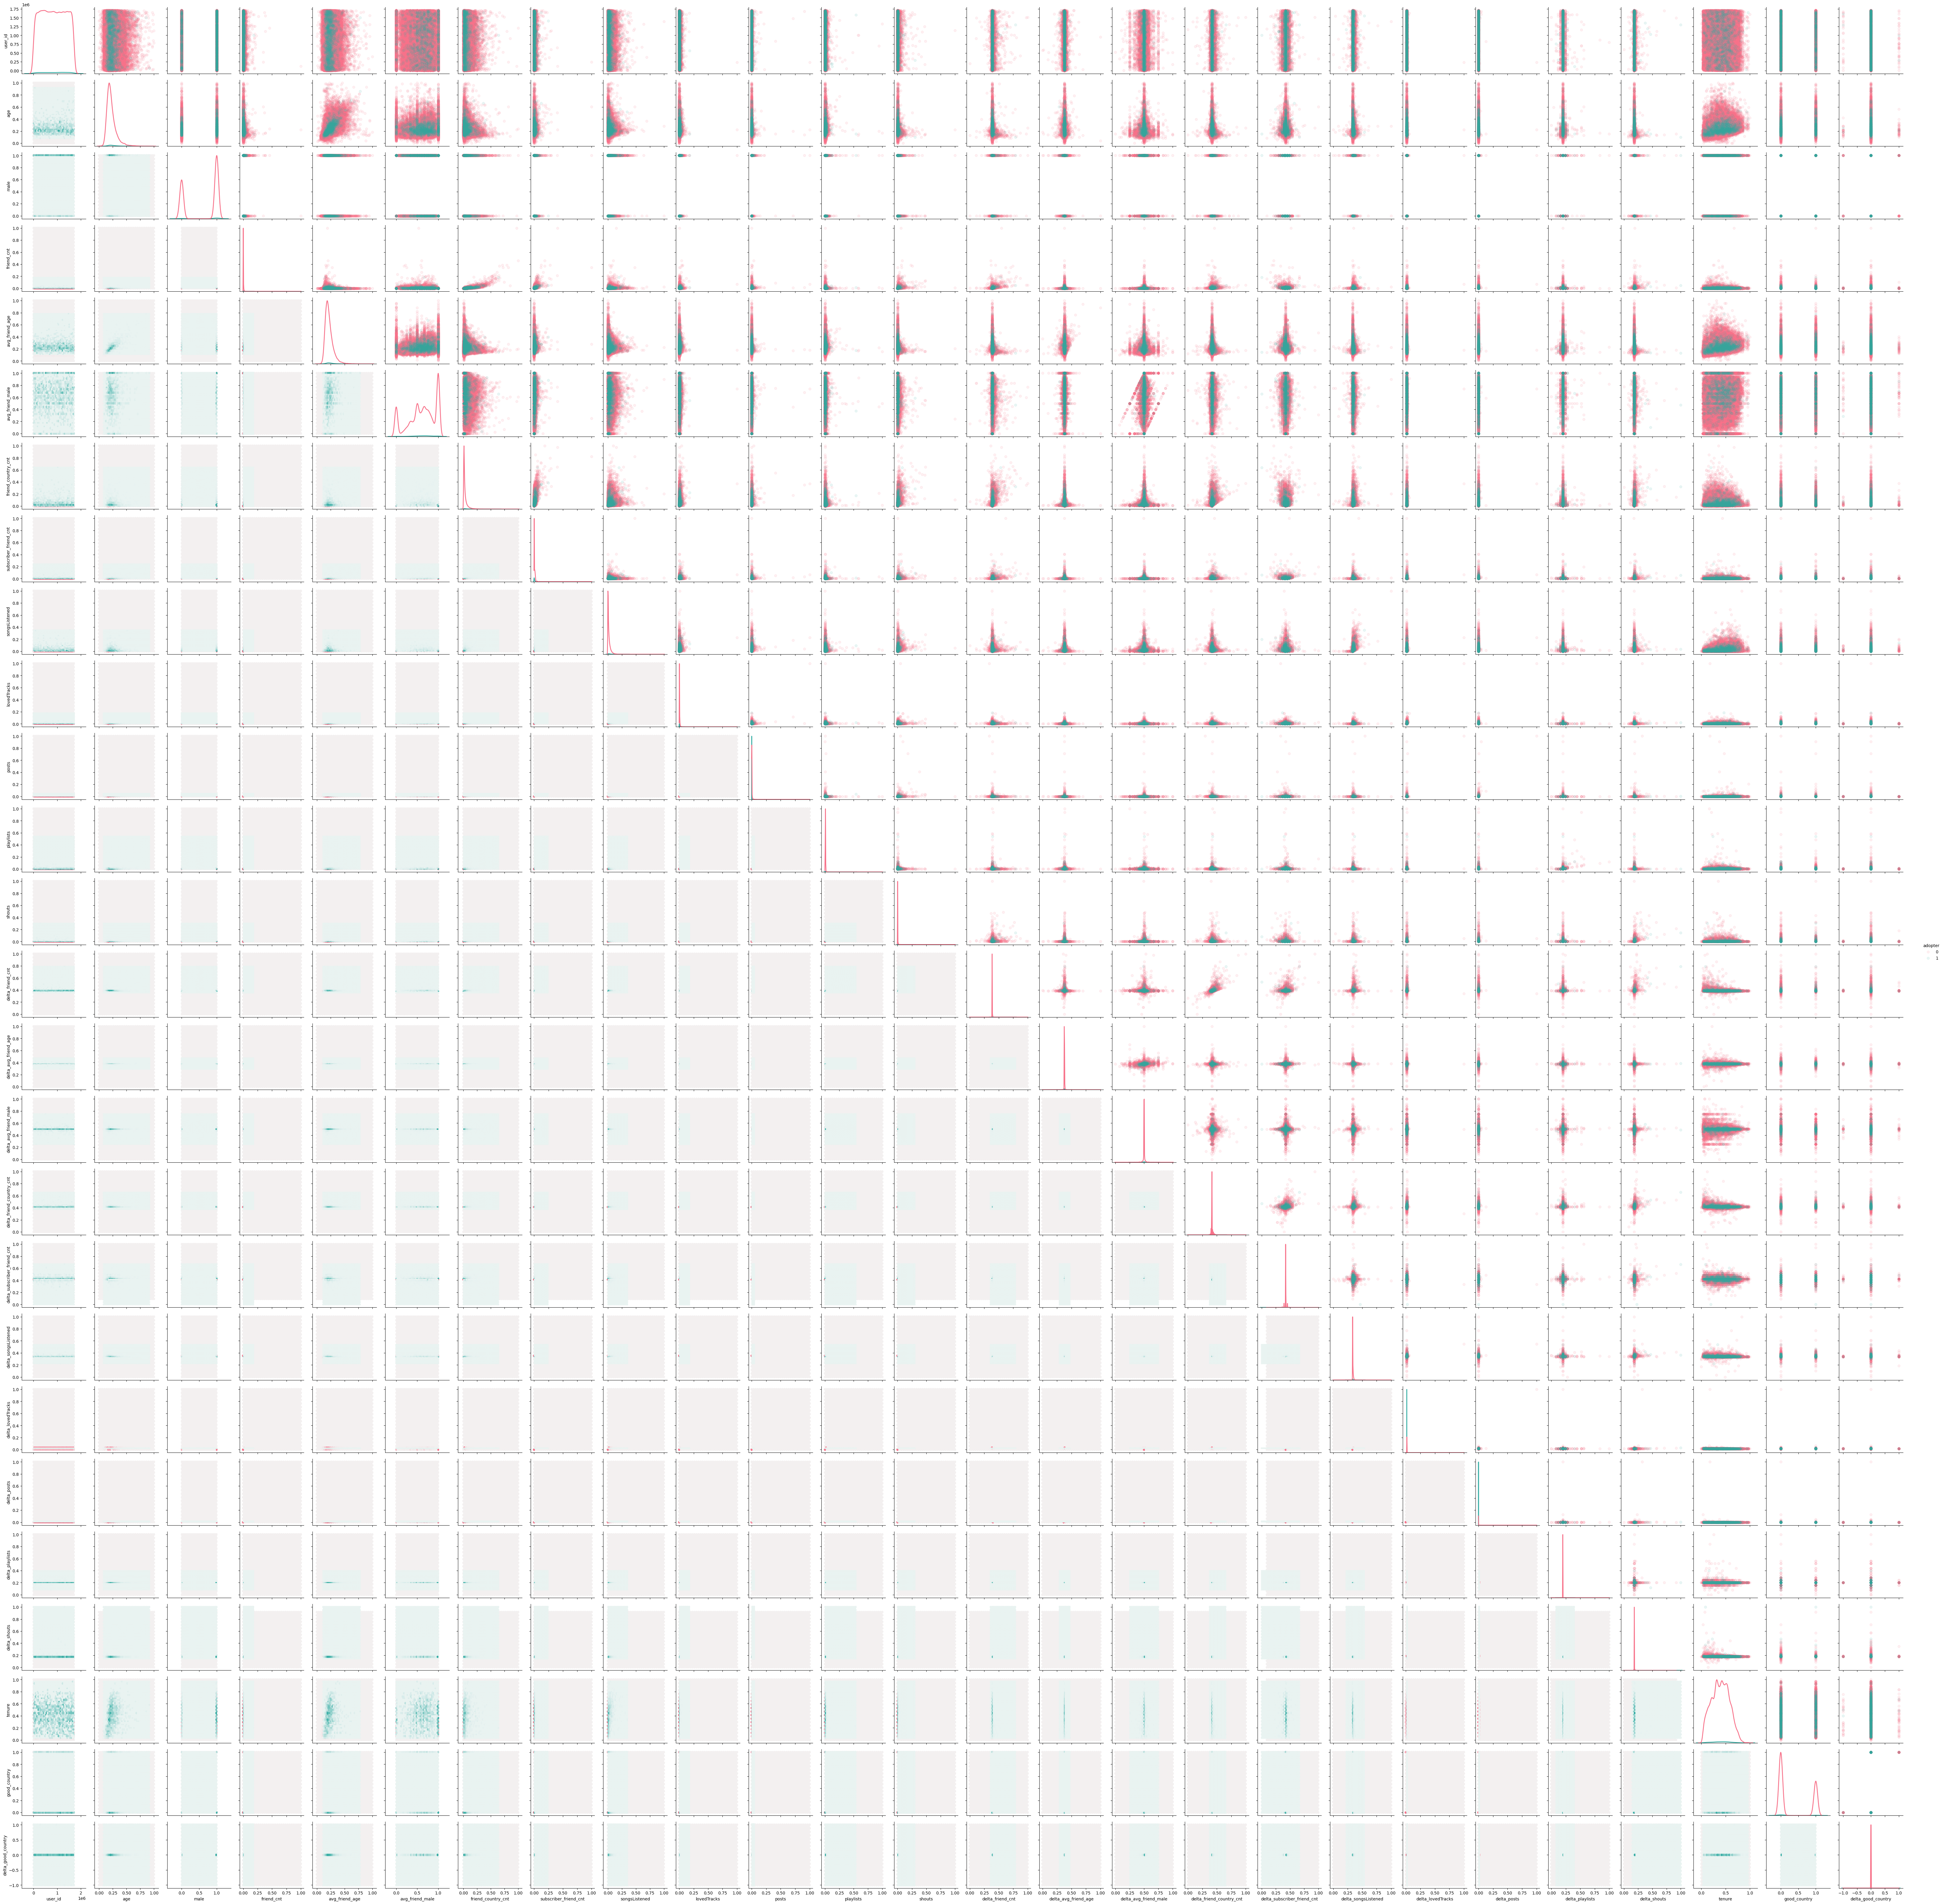

In [10]:
# Scatter Plots

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=30, cmap=cmap, **kwargs)


selected_features = ["age", "friend_cnt", "songsListened",
                     "lovedTracks", "playlists", "tenure", "adopter"]

# Set custom palette for adopter and non-adopter
palette = sns.color_palette("husl", 2)

g = sns.PairGrid(labeledData, hue="adopter",
                 palette=palette, diag_sharey=False)
g.map_lower(hexbin)
g.map_diag(sns.kdeplot, lw=2)
g.map_upper(plt.scatter, alpha=0.1)

g.add_legend()
plt.show()


# Feature selection
Perform feature selection to identify the most important features that contribute to the model's predictive performance. Techniques like correlation analysis, recursive feature elimination (RFE), or regularization methods (Lasso, Ridge, or ElasticNet) can be used for this purpose.

In [44]:
# Calculate the correlation matrix
corr_matrix = labeledData.corr()

# Get correlations between features and the target variable ('adopter')
correlations_with_target = corr_matrix['adopter'].sort_values(ascending=False)

# Set a threshold for the minimum correlation
threshold = 0.05

# Select features with a correlation above the threshold (in absolute value)
CA_selected_features = correlations_with_target[correlations_with_target.abs(
) > threshold].drop('adopter').index.tolist()
print("Selected features based on correlation analysis:")
print(CA_selected_features)


Selected features based on correlation analysis:
['subscriber_friend_cnt', 'songsListened', 'lovedTracks', 'friend_country_cnt', 'delta_songsListened']


In [36]:
# Separate the target variable from the features
X = labeledData.drop('adopter', axis=1)
y = labeledData['adopter']

# Scale the features (useful for some models like logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate the logistic regression model
estimator = LogisticRegression(solver='liblinear')

# Define the number of features to select
n_features_to_select = 10

# Create the RFE object
rfe = RFE(estimator, n_features_to_select=n_features_to_select)

# Fit RFE to the dataset
rfe.fit(X_scaled, y)

# Get the selected features
RFE_selected_features = X.columns[rfe.support_].tolist()

print("Selected features using RFE:")
print(RFE_selected_features)


Selected features using RFE:
['age', 'male', 'friend_cnt', 'avg_friend_age', 'friend_country_cnt', 'subscriber_friend_cnt', 'songsListened', 'lovedTracks', 'delta_posts', 'good_country']


In [35]:
# Separate the target variable from the features
X = labeledData.drop('adopter', axis=1)
y = labeledData['adopter']

# Scale the features (useful for regularization methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instantiate the Lasso model with an appropriate alpha value
alpha = 0.005
lasso = Lasso(alpha=alpha)

# Fit the Lasso model to the dataset
lasso.fit(X_scaled, y)

# Get the non-zero coefficients
non_zero_coeff = lasso.coef_ != 0
LR_selected_features = X.columns[non_zero_coeff].tolist()

print("Selected features using Lasso regularization:")
print(LR_selected_features)


Selected features using Lasso regularization:
['age', 'subscriber_friend_cnt', 'songsListened', 'lovedTracks', 'delta_songsListened']


# Testing the Feature Selections
This code will train a RandomForestClassifier model using each set of selected features and evaluate their performance on the validation set using the F1-score.

In [47]:
# Define the different models to test
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42)
}

# Define the different feature sets to test
feature_sets = {
    "Correlation Analysis": CA_selected_features,
    "Recursive Feature Elimination": RFE_selected_features,
    "Lasso Regularization": LR_selected_features
}

# Loop over the feature sets and models and print the F1-score for each combination
for feature_set_name, selected_features in feature_sets.items():
    # Get the indices of the selected features
    selected_indices = [X.columns.get_loc(
        feature) for feature in selected_features]

    # Select the features for the current feature set
    X_train_fs = X_train_smote.iloc[:, selected_indices]
    X_val_fs = X_val.iloc[:, selected_indices]

    # Loop over the models and fit the model on the training set, make predictions on the validation set, and calculate the F1-score
    for model_name, model in models.items():
        # Fit the model on the training set
        model.fit(X_train_fs, y_train_smote)

        # Make predictions on the validation set
        y_pred = model.predict(X_val_fs)

        # Calculate the F1-score
        f1 = f1_score(y_val, y_pred)

        # Print the model name, feature set name, and F1-score
        print(f"{model_name} with {feature_set_name} F1-score: {f1:.4f}")


Random Forest with Correlation Analysis F1-score: 0.0575
Logistic Regression with Correlation Analysis F1-score: 0.0718
SVM with Correlation Analysis F1-score: 0.0759
XGBoost with Correlation Analysis F1-score: 0.0523


C:\Users\Marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with Correlation Analysis F1-score: 0.0764
Random Forest with Recursive Feature Elimination F1-score: 0.0827
Logistic Regression with Recursive Feature Elimination F1-score: 0.0647
SVM with Recursive Feature Elimination F1-score: 0.0679
XGBoost with Recursive Feature Elimination F1-score: 0.0287


C:\Users\Marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with Recursive Feature Elimination F1-score: 0.0904
Random Forest with Lasso Regularization F1-score: 0.0690
Logistic Regression with Lasso Regularization F1-score: 0.0717
SVM with Lasso Regularization F1-score: 0.0814
XGBoost with Lasso Regularization F1-score: 0.0054
Neural Network with Lasso Regularization F1-score: 0.0799


C:\Users\Marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Feature Selection Results

The F1-scores have improved compared to the initial results, indicating that the models are now able to make better predictions on the validation set. 
The Recursive Feature Elimination (RFE) feature set provided the best F1-score at 0.0827. 
Although this is an improvement over the baseline model's F1-score of 0.0707, there is still room for improvement.

## Further optimize the model by:

- Trying other classification algorithms such as XGBoost or Support Vector Machines (SVM).
- Performing hyperparameter tuning using techniques like Grid Search or Randomized Search for the chosen classifier.
- Experimenting with other feature selection techniques or combining the results of multiple techniques.
- Exploring other techniques to handle imbalanced data, such as different oversampling or undersampling methods.


In [48]:
print(labeledData['adopter'].value_counts())

0    57048
1     1029
Name: adopter, dtype: int64


# Here are the models that had F1-scores over 0.075:
1. Neural Network with Recursive Feature Elimination F1-score: 0.0904
2. Random Forest with Recursive Feature Elimination F1-score: 0.0827
3. SVM with Lasso Regularization F1-score: 0.0814
4. Neural Network with Lasso Regularization F1-score: 0.0799
5. Neural Network with Correlation Analysis F1-score: 0.0764
6. SVM with Correlation Analysis F1-score: 0.0759

In [51]:
# 1. Neural Network with Recursive Feature Elimination F1-score: 0.0904
# 2. Random Forest with Recursive Feature Elimination F1-score: 0.0827
# 3. SVM with Lasso Regularization F1-score: 0.0814

# Voting Classifier: One way to ensemble the models is to use a voting classifier. This involves combining the predictions of the three models and selecting the most common prediction as the final prediction

# Instantiate the three models
nn = MLPClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('nn', nn), ('rf', rf), ('svm', svm)], voting='hard')

# Train the voting classifier on the training set
voting_clf.fit(X_train_fs, y_train_smote)

# Make predictions on the validation set
y_pred = voting_clf.predict(X_val_fs)

# Calculate the F1-score
f1 = f1_score(y_val, y_pred)

# Print the F1-score
print(f"Ensemble (Voting Classifier) F1-score: {f1:.4f}")


C:\Users\Marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble (Voting Classifier) F1-score: 0.0884


# Debugging XGB Model

In [73]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold

X = labeledData.drop(['adopter', 'user_id'], axis=1)
y = labeledData['adopter']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)

smote = BorderlineSMOTE(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eta': 0.3,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric': 'error'
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []

for train_idx, val_idx in kf.split(X_train_resampled):
    dtrain_kf = xgb.DMatrix(data=X_train_resampled.iloc[train_idx], label=y_train_resampled.iloc[train_idx])
    dval_kf = xgb.DMatrix(data=X_train_resampled.iloc[val_idx], label=y_train_resampled.iloc[val_idx])

    xgb_model = xgb.train(params=params, dtrain=dtrain_kf, num_boost_round=100, early_stopping_rounds=10,evals=[(dval_kf, 'val'), (dtrain_kf, 'train')], verbose_eval=10)

    y_val_pred = xgb_model.predict(dval_kf)
    y_val_pred = np.where(y_val_pred > 0.5, 1, 0)

    xgb_f1 = f1_score(y_train_resampled.iloc[val_idx], y_val_pred)
    f1_scores.append(xgb_f1)

print("Average F1 Score on validation set: {:.4f}".format(np.mean(f1_scores)))

# Evaluate the model on the test set
dtest = xgb.DMatrix(data=X_val, label=y_val)
y_test_pred = xgb_model.predict(dtest)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

test_f1_score = f1_score(y_val, y_test_pred)
print(f"Average F1 Score on test set: {test_f1_score:.4f}")


[0]	val-error:0.14159	train-error:0.13912
[10]	val-error:0.08673	train-error:0.07925
[20]	val-error:0.06276	train-error:0.05480
[30]	val-error:0.05034	train-error:0.04086
[40]	val-error:0.04023	train-error:0.03107
[50]	val-error:0.03542	train-error:0.02366
[60]	val-error:0.03186	train-error:0.01954
[70]	val-error:0.02926	train-error:0.01552
[80]	val-error:0.02628	train-error:0.01227
[90]	val-error:0.02455	train-error:0.01064
[99]	val-error:0.02397	train-error:0.00960
[0]	val-error:0.13822	train-error:0.13202
[10]	val-error:0.08730	train-error:0.07949
[20]	val-error:0.06555	train-error:0.05631
[30]	val-error:0.05025	train-error:0.03983
[40]	val-error:0.04303	train-error:0.03333
[50]	val-error:0.03513	train-error:0.02397
[60]	val-error:0.03090	train-error:0.01959
[70]	val-error:0.02917	train-error:0.01581
[80]	val-error:0.02695	train-error:0.01328
[90]	val-error:0.02406	train-error:0.01066
[99]	val-error:0.02252	train-error:0.00912
[0]	val-error:0.14064	train-error:0.13361
[10]	val-error